# 1. Import Libraries

In [20]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

# 2. Read Dataset

In [2]:
df = pd.read_csv('data/all-data.csv', encoding='latin_1', header=None)
df.head(10)

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,positive,"For the last quarter of 2010 , Componenta 's n..."
7,positive,"In the third quarter of 2010 , net sales incre..."
8,positive,Operating profit rose to EUR 13.1 mn from EUR ...
9,positive,"Operating profit totalled EUR 21.1 mn , up fro..."


In [3]:
df.columns = ['sentiment', 'news_title']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentiment   4846 non-null   object
 1   news_title  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


# 3. Data Cleansing

## 3.1. Duplicate Values Detection

In [9]:
df.duplicated().sum()

0

Since there are six duplicates, we drop those duplicates.

In [10]:
df.drop_duplicates(inplace=True)

## 3.2. Missing Values Detection

In [11]:
df.isnull().values.any()

False

There is no missing values.

## 3.3 Text Preprocessing

In [12]:
def clean_text(text):
    # Step 1: Convert text to lowercase
    text = text.lower()
    # Step 2: Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Step 3: Tokenization (split text into words)
    tokens = word_tokenize(text)
    # Step 4: Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Step 5: Join tokens back into cleaned text
    cleaned_text = " ".join(filtered_tokens)
    
    return cleaned_text

In [13]:
df['news_title'] = df['news_title'].apply(clean_text)

In [14]:
df.head()

,sentiment,news_title
0,neutral,according gran company plans move production r...
1,neutral,technopolis plans develop stages area less squ...
2,negative,international electronic industry company elco...
3,positive,new production plant company would increase ca...
4,positive,according company updated strategy years baswa...


# 4. Data Exploration

## 4.1. Sentiment Distribution

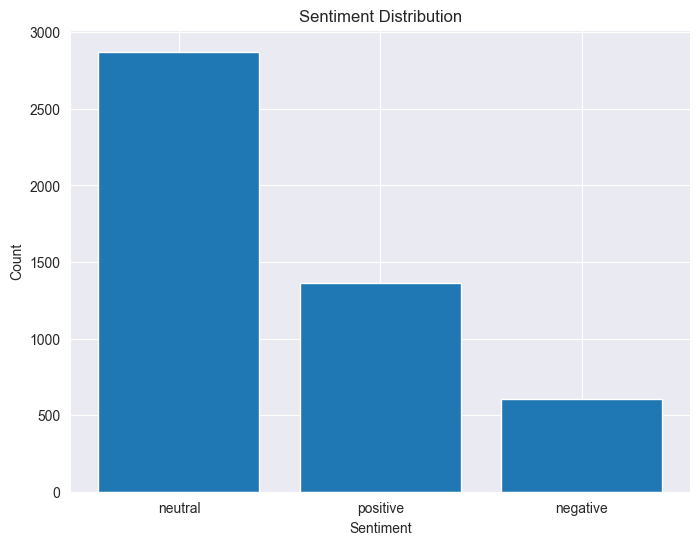

In [15]:
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

## 4.2. Text Length Distribution by Sentiment

/Users/kohtaasakura/Library/Caches/pypoetry/virtualenvs/financialnewssentiment-OsNV2T2z-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kohtaasakura/Library/Caches/pypoetry/virtualenvs/financialnewssentiment-OsNV2T2z-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/kohtaasakura/Library/Caches/pypoetry/virtualenvs/financialnewssentiment-OsNV2T2z-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtyp

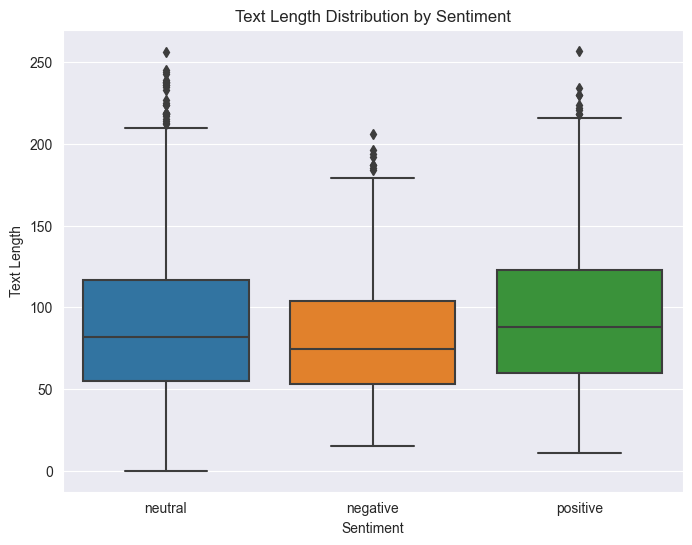

In [16]:
# Calculate text length for each sample
df['text_length'] = df['news_title'].apply(len)

# Create box plots to visualize text length by sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='sentiment', y='text_length')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.title('Text Length Distribution by Sentiment')
plt.show()

## 4.3. Word Cloud

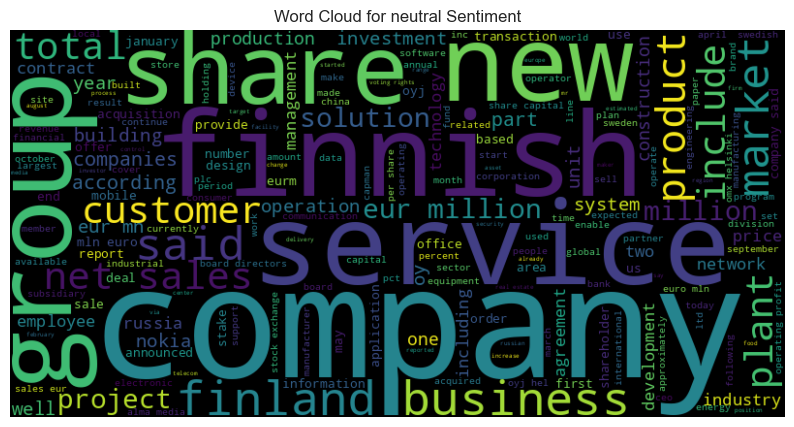

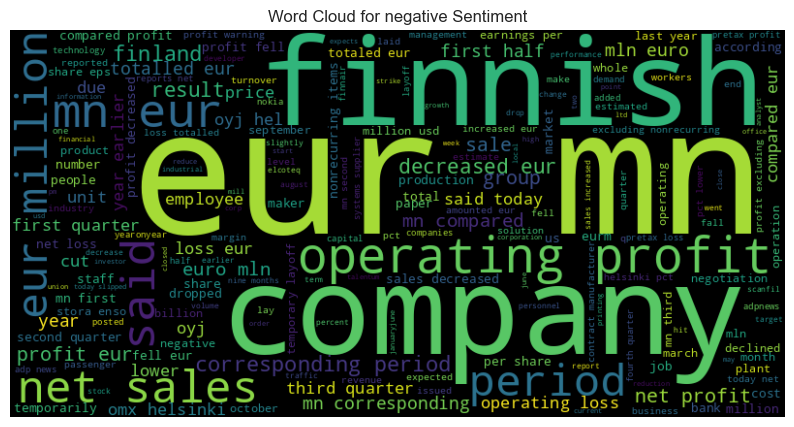

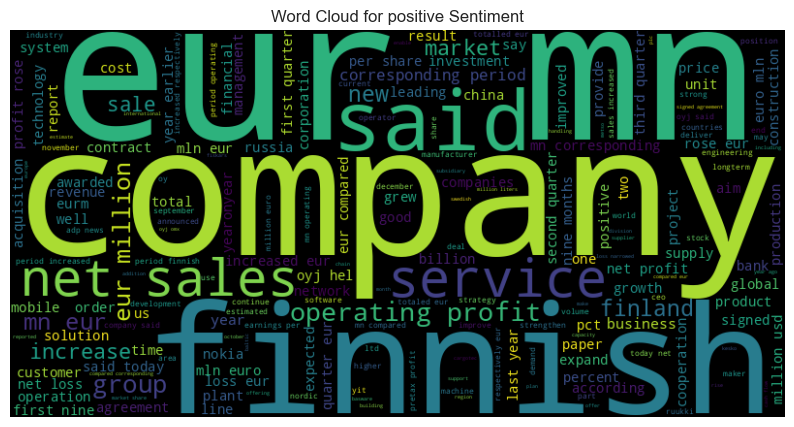

In [17]:
# Create a word cloud for each sentiment category
sentiment_categories = df['sentiment'].unique()
for sentiment in sentiment_categories:
    text_for_sentiment = " ".join(df[df['sentiment'] == sentiment]['news_title'])
    wordcloud = WordCloud(width=800, height=400).generate(text_for_sentiment)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.axis("off")
    plt.show()

# 5. SVM

## 5.1. TF-IDF Vectorization

In [19]:
# Split the data into features (X) and labels (y)
X = df["news_title"]
y = df["sentiment"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer and transform the text data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## 5.2. SVM Hyperparameter Tuning / Training

In [21]:
param_grid = {
    'C': [0.1, 1, 10],           # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': [0.01, 0.1, 1]      # Kernel coefficient (only for some kernels)
}

# Create the SVM classifier
svm_classifier = SVC()

# Initialize the GridSearchCV
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [22]:
# Print the best parameters
print("Best Parameters:")
print(best_params)

Best Parameters:
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [23]:
# Use the best estimator for prediction
y_pred = best_estimator.predict(X_test_tfidf)

## 5.3. SVM Evaluation

Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.58      0.67       118
     neutral       0.79      0.90      0.84       563
    positive       0.72      0.60      0.65       287

    accuracy                           0.77       968
   macro avg       0.76      0.69      0.72       968
weighted avg       0.77      0.77      0.76       968


Confusion Matrix:


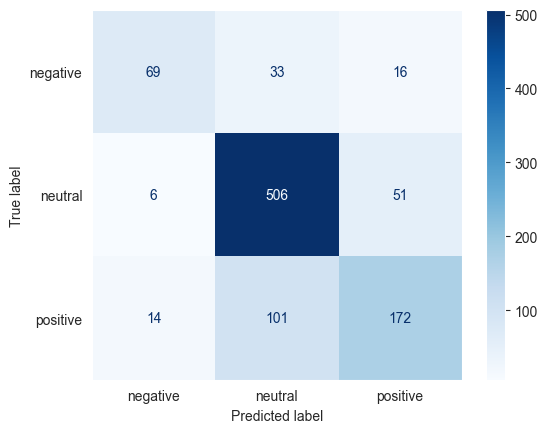

In [26]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap='Blues')
plt.grid(False)
plt.show()

# 6. Logistic Regression

## 6.1 Logistic Regression Training

In [27]:
# Create a logistic regression model
logistic_regression = LogisticRegression()

# Train the model on the training data
logistic_regression.fit(X_train_tfidf, y_train)

LogisticRegression()

In [28]:
y_pred = logistic_regression.predict(X_test_tfidf)

## 6.2. Logistic Regression Evaluation

Accuracy: 0.74

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.39      0.52       118
     neutral       0.73      0.96      0.83       563
    positive       0.80      0.46      0.59       287

    accuracy                           0.74       968
   macro avg       0.78      0.60      0.65       968
weighted avg       0.76      0.74      0.72       968


Confusion Matrix:


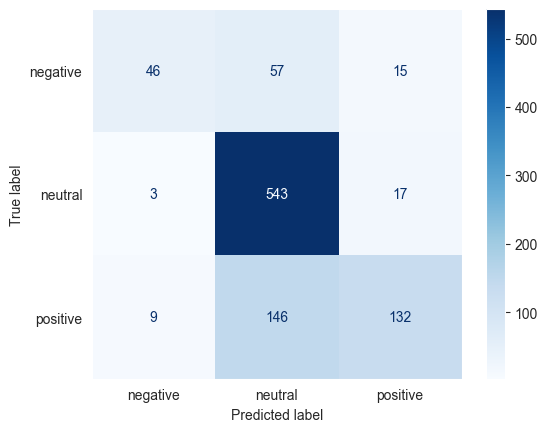

In [29]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap='Blues')
plt.grid(False)
plt.show()